In [1]:
from fastai.vision.all import *
from tqdm import tqdm
import albumentations as A
from albumentations import functional as F

In [2]:
import torch
torch.backends.cudnn.benchmark = True

In [3]:
DATA_PATH = Path('data')
TRAIN_PATH = DATA_PATH / 'train_features'
LABEL_PATH = DATA_PATH / 'train_labels'

In [4]:
df = pd.read_csv(DATA_PATH / 'train_ready.csv')
df.head(1)

,chip_id,location,datetime,cloudpath,is_valid,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,False,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif


In [5]:
IMG_SIZE = 512
BS = 3
DEBUG = None ## Size of development set or None

In [6]:
class Chips:
    def __init__(self, src_path, df_path, debug = None):
        self.src_path = src_path
        self.debug = debug
        self.names = self._get_chips(src_path)
        self.df = pd.read_csv(df_path)
        self.train_idx = self.names.argwhere(self._is_valid, negate = True)
        self.valid_idx = self.names.argwhere(self._is_valid)
        assert(len(self.train_idx) + len(self.valid_idx) == len(self.names))
        assert(len(set(self.train_idx).intersection(set(self.valid_idx))) == 0)
    
    def _is_valid(self, chip):
        return self.df.loc[self.df['chip_id'] == chip, 'is_valid'].item()
    
    def _get_chips(self, path):
        potential_chips = list(path.iterdir())
        chips_paths = [chip for chip in potential_chips if chip.is_dir()]
        if self.debug:
            chips_paths = random.choices(chips_paths, k = self.debug)
        return L(chips_paths).attrgot('name')
    
    def describe(self):
        print(f'Number of validation items: {len(self.valid_idx)}, number of training items: {len(self.train_idx)}\nTotal number of items: {len(self.names)}')
        
    def get_train_chips(self):
        return self.names[self.train_idx]
    
    def get_valid_chips(self):
        return self.names[self.valid_idx]
    
    def get_splits(self):
        return [self.train_idx, self.valid_idx]

In [7]:
class ChipDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid = False):
        self.files = files
        self.is_valid = is_valid
        
    def __getitem__(self, i):
        chip = self.files[i]
        img = self._get_multiband_img(chip)
        mask = self._get_mask(chip)
        return (img, mask)
    
    def __len__(self): 
        return len(self.files)
    
    def _get_multiband_img(self, chip):
        blue  = self._get_array(chip, 'B02')
        green = self._get_array(chip, 'B03')
        red   = self._get_array(chip, 'B04')
        infra = self._get_array(chip, 'B08')
        stack = np.stack([blue, green, red, infra], axis = -1)
        return TensorImage(stack).float()
    
    @staticmethod
    def _get_mask(chip):
        fn = (LABEL_PATH / chip).with_suffix('.tif')
        return TensorImage(Image.open(fn)).float()
    
    @staticmethod
    def _get_array(chip, band):
        fn = (TRAIN_PATH / chip /band).with_suffix('.tif')
        if fn.exists():
            return (np.array(Image.open(fn)) / 27000)
        else:
            return np.zeros((512, 512))

In [8]:
chips = Chips(TRAIN_PATH, DATA_PATH / 'train_ready.csv', debug = DEBUG)
chips.describe()

Number of validation items: 2442, number of training items: 9306
Total number of items: 11748


In [9]:
augs_list = A.Compose(
    [
     A.Flip(),
     #A.RandomCrop(440, 440)
    ]
)

class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        augs = []
        for img,mask in x:
            aug = self.aug(image=np.array(img), mask=np.array(mask))
            augs.append((TensorImage(aug["image"].transpose(2,0,1)), TensorMask(aug["mask"])))
        return augs
    
aug_tfms = SegmentationAlbumentationsTransform(augs_list)

In [10]:
train_ds = ChipDataset(chips.get_train_chips())
valid_ds = ChipDataset(chips.get_valid_chips(), True)

dls = DataLoaders.from_dsets(
    train_ds, 
    valid_ds, 
    bs = BS, 
    num_workers = 6, 
    pin_memory = True,
    device = 'cuda',
    #after_item = []
    before_batch = [aug_tfms]
    #after_batch = []
)

In [11]:
b = dls.one_batch()
print(b[0].shape, b[1].shape)

torch.Size([3, 4, 512, 512]) torch.Size([3, 512, 512])


In [12]:
class CrossLossLong(CrossEntropyLossFlat):
    def __call__(self, inp, targ, **kwargs):
        inp,targ  = map(self._contiguous, (inp,targ))
        targ = targ.long()
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)

In [13]:
n_channels, *img_size = dls.one_batch()[0].shape[-3:]

model = create_unet_model(
    arch = resnet34,
    n_out = 2,
    img_size = img_size,
    n_in = n_channels
)

_default_meta    = {'cut':None, 'split':default_split}
meta = model_meta.get(resnet34, _default_meta)

learn = Learner(
    dls,
    model,
    #loss_func = CrossEntropyLossFlat(axis = 1),
    loss_func = CrossLossLong(axis = 1),
    metrics = [Dice, JaccardCoeff],
    splitter = meta['split']
)

learn.freeze()

SuggestedLRs(valley=0.0004786300996784121)

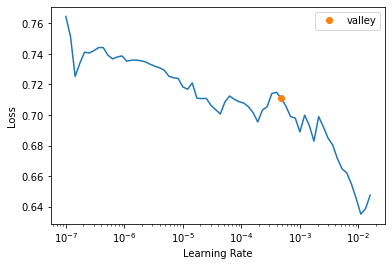

In [14]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.340051,0.269438,0.930164,0.869446,22:29


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.269811,0.196104,0.942309,0.890912,23:31
1,0.263490,0.231404,0.937318,0.882030,23:31
2,0.248429,0.182504,0.944396,0.894649,24:30
3,0.207560,0.170043,0.948156,0.901423,24:55


# Time overview:
* without tfms: 22:30 min | __baseline__
* with flip transforms: 8:15min | but something is wrong

In [ ]:
#learn.fine_tune(5, 1e-4)

In [ ]:
#result_metric = None
#learn.export(f'res34_{IMG_SIZE}_j{905}')